In [1]:
import numpy as np
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

remove prev saved database:

In [2]:
dir_path = './data/humanModel/dataset_split'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
else:
    print("File not found in the directory")

# Part 1 - Data Preprocessing

## Split into train , test data

In [3]:
# train, test split
splitfolders.ratio('./data/humanModel/dataset/', output=dir_path, ratio=(0.85, 0.15))

Copying files: 8949 files [00:00, 13156.71 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 128
IMG_SIZE = 5

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory((dir_path+'/train'),
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory((dir_path+'/val'),
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 7605 images belonging to 2 classes.
Found 1344 images belonging to 2 classes.


## View some data

In [5]:
ACTION_NUM = 2
RATE_VECTOR_LEN = 5

# Define model layers.
input_layer = Input(shape=(IMG_SIZE,IMG_SIZE,3))
X = Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
X = Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
X = Conv2D(8, 2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
X = Dropout(0.5)(X)
X = Flatten()(X)
X = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
action_output = Dense(ACTION_NUM, activation='softmax', name='action_output')(X)
model = Model(inputs=input_layer,outputs=action_output)

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 5, 3)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 4)           112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 8)           296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 8)           264       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                12864 

In [8]:
epochs=175
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

Epoch 1/175


/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


60/60 [==============================] - 3s 25ms/step - loss: 0.7707 - accuracy: 0.5557 - val_loss: 0.7472 - val_accuracy: 0.5573
Epoch 2/175
60/60 [==============================] - 2s 25ms/step - loss: 0.7336 - accuracy: 0.5575 - val_loss: 0.7208 - val_accuracy: 0.5588
Epoch 3/175
60/60 [==============================] - 1s 21ms/step - loss: 0.7156 - accuracy: 0.5586 - val_loss: 0.7096 - val_accuracy: 0.5558
Epoch 4/175
60/60 [==============================] - 1s 18ms/step - loss: 0.7055 - accuracy: 0.5596 - val_loss: 0.7007 - val_accuracy: 0.5588
Epoch 5/175
60/60 [==============================] - 1s 21ms/step - loss: 0.6986 - accuracy: 0.5615 - val_loss: 0.6959 - val_accuracy: 0.5774
Epoch 6/175
60/60 [==============================] - 1s 24ms/step - loss: 0.6925 - accuracy: 0.5699 - val_loss: 0.6884 - val_accuracy: 0.5640
Epoch 7/175
60/60 [==============================] - 1s 24ms/step - loss: 0.6872 - accuracy: 0.5734 - val_loss: 0.6831 - val_accuracy: 0.5722
Epoch 8/175
60/60 

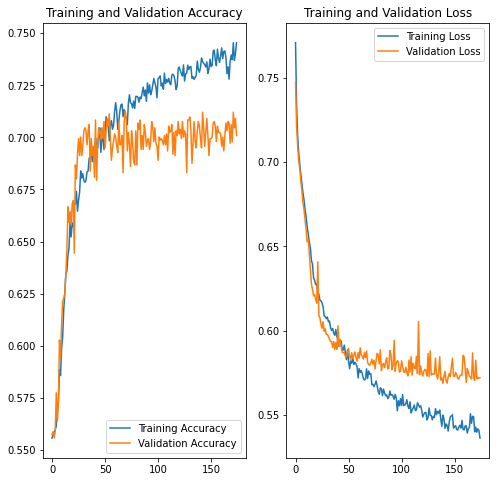

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

11/11 [==============================] - 0s 12ms/step - loss: 0.5720 - accuracy: 0.7009
Test accuracy : 0.7008928656578064


In [11]:
y_pred = model.predict(test).argmax(axis=-1)
y_true = test.classes

m = tf.keras.metrics.Precision()
m.update_state(y_pred, y_true)
print("Precision: " , m.result().numpy())

m = tf.keras.metrics.Recall()
m.update_state(y_pred, y_true)
print("Recall: " , m.result().numpy())

Precision:  0.6644474
Recall:  0.54654986


In [12]:
tf.math.confusion_matrix(y_pred, y_true)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[179, 252],
       [414, 499]], dtype=int32)>

In [13]:
# Save the weights model.
model.save('./data/humanModel/dropout_model_v2.h5')

In [14]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [15]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

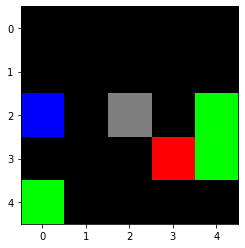

This image most likely belongs to closest_bush with a 73.86 percent confidence.
True class is closest_bush.


In [16]:
import glob

classes = ['closest_bush', 'follow_stag']
random_class = random.choice(classes)

path = "./data/humanModel/dataset_split/val/"+random_class
all_images_path = glob.glob(path + "/*.png")
random_path = random.choice(all_images_path)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(random_path)
imgplot = plt.imshow(img)
plt.show()

img = keras.preprocessing.image.load_img(
    random_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255

predictions = model.predict(img_array)[0]


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(predictions)], 100 * np.max(predictions))
)
print("True class is {}.".format(random_class))